In [135]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pickle
import json
import random
import matplotlib.pyplot as plt
import networkx as nx
import random

import multiprocessing as mp
import swifter
print('CPU numbers:',mp.cpu_count())
def _apply_df(args):
    df, func, kwargs = args
    return df.apply(func, **kwargs)
def apply_by_multiprocessing(df, func, **kwargs):
#     print(kwargs)
    workers = kwargs.pop('workers')
    pool = mp.Pool(processes=workers)
    result = pool.map(_apply_df, [(d, func, kwargs) for d in np.array_split(df, workers)])
    pool.close()
    return pd.concat(list(result))
#apply_by_multiprocessing(fullset['Text'], process_text, workers=cores)

df = pd.read_csv('./user_taggedmovies.dat',sep="\s+", )
df

CPU numbers: 32


,userID,movieID,tagID,date_day,date_month,date_year,date_hour,date_minute,date_second
0,75,353,5290,29,10,2006,23,20,15
1,78,4223,5264,16,4,2007,4,43,45
2,127,1343,1544,28,8,2007,3,42,27
3,127,1343,12330,28,8,2007,3,42,27
4,127,2080,1451,28,8,2007,3,42,47
...,...,...,...,...,...,...,...,...,...
47952,71534,7937,306,3,12,2007,3,7,14
47953,71534,8848,331,3,12,2007,3,6,19
47954,71534,8848,427,3,12,2007,3,6,27
47955,71534,25833,7671,3,12,2007,3,7,31


In [114]:
df.loc[:,'timestamps'] = df.date_year.astype('str')+'_'+ df.date_month.astype('str')+'_'+ df.date_day.astype('str')+'_'+ \
df.date_hour.astype('str')+'_'+df.date_minute.astype('str')+'_'+df.date_second.astype('str')

df.loc[:,'timestamps'] = df.loc[:,'timestamps'].apply(pd.to_datetime,format='%Y_%m_%d_%H_%M_%S')
df['dayofweek_num']=df['timestamps'].dt.dayofweek  
df['weekofyear']=df['timestamps'].dt.weekofyear
df['quarter']=df['timestamps'].dt.quarter
df['days_in_month']=df['timestamps'].dt.days_in_month
df['is_month_start']=df['timestamps'].dt.is_month_start
df['is_month_end']=df['timestamps'].dt.is_month_end
df['is_quarter_start']=df['timestamps'].dt.is_quarter_start
df['is_quarter_end']=df['timestamps'].dt.is_quarter_end
df['is_year_start']=df['timestamps'].dt.is_year_start
df['is_year_end']=df['timestamps'].dt.is_year_end
df['is_leap_year']=df['timestamps'].dt.is_leap_year

In [116]:
df = df.sort_values(by=['timestamps']) # test集是否只采样最晚的数据
df.reset_index(drop=True, inplace=True)
df

,userID,movieID,tagID,date_day,date_month,date_year,date_hour,date_minute,date_second,timestamps,...,weekofyear,quarter,days_in_month,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_leap_year
0,71331,1396,542,23,12,2005,19,13,0,2005-12-23 19:13:00,...,51,4,31,False,False,False,False,False,False,False
1,22198,4011,520,24,12,2005,14,3,51,2005-12-24 14:03:51,...,51,4,31,False,False,False,False,False,False,False
2,22198,2329,8336,24,12,2005,14,5,8,2005-12-24 14:05:08,...,51,4,31,False,False,False,False,False,False,False
3,5829,8573,8426,30,12,2005,10,50,23,2005-12-30 10:50:23,...,52,4,31,False,False,False,False,False,False,False
4,14895,38886,752,31,12,2005,14,43,32,2005-12-31 14:43:32,...,52,4,31,False,True,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47952,62847,2802,870,4,1,2009,23,4,17,2009-01-04 23:04:17,...,1,1,31,False,False,False,False,False,False,False
47953,62847,2247,2444,4,1,2009,23,5,18,2009-01-04 23:05:18,...,1,1,31,False,False,False,False,False,False,False
47954,62847,1721,1259,4,1,2009,23,6,38,2009-01-04 23:06:38,...,1,1,31,False,False,False,False,False,False,False
47955,62847,1554,4800,4,1,2009,23,7,5,2009-01-04 23:07:05,...,1,1,31,False,False,False,False,False,False,False


In [332]:
# 末端采样为test
# train_size = int(len(df_selected) * 0.8)
# train, test = df.iloc[:train_size,:], df_selected.iloc[train_size:,:]

# 随机采样
from sklearn.model_selection import train_test_split
train, test, = train_test_split(df, test_size=0.2, random_state=0)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
train.shape, test.shape

((38365, 21), (9592, 21))

In [333]:
df_selected = train.filter(regex="[^time_stamp]")
df_selected = df_selected.iloc[:,:]
cols = df_selected.columns
df_selected.reset_index(drop=True, inplace=True)
df_selected

,userID,movieID,tagID,date_day,date_month,date_year,date_hour,date_minute,date_second,dayofweek_num,weekofyear,quarter,days_in_month,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_leap_year
0,1751,539,892,17,1,2006,21,3,30,1,3,1,31,False,False,False,False,False,False,False
1,23087,8225,641,3,2,2007,0,21,31,5,5,1,28,False,False,False,False,False,False,False
2,20438,8607,11,4,1,2007,6,39,9,3,1,1,31,False,False,False,False,False,False,False
3,23172,1221,1974,3,4,2008,20,10,37,3,14,2,30,False,False,False,False,False,False,True
4,23172,661,5109,4,2,2006,7,16,13,5,5,1,28,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38360,23388,3814,4282,10,2,2007,23,42,42,5,6,1,28,False,False,False,False,False,False,False
38361,37957,7346,16039,29,10,2008,12,22,14,2,44,4,31,False,False,False,False,False,False,True
38362,23172,3176,11246,9,5,2008,16,59,22,4,19,2,31,False,False,False,False,False,False,True
38363,18666,5481,1457,19,6,2008,20,8,34,3,25,2,30,False,False,False,False,False,False,True


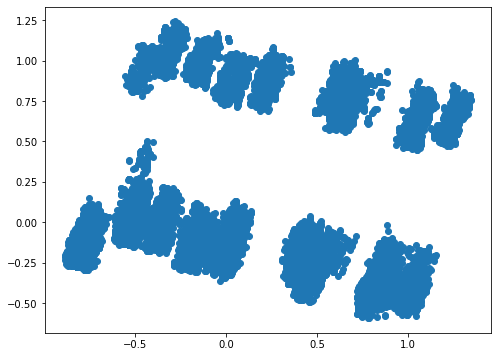

In [338]:
scaler = MinMaxScaler()
df_selected = scaler.fit_transform(df_selected)
# scaler.inverse_transform(df_selected)
pca = PCA()
vectors = pca.fit_transform(df_selected)#高维度PCA降维到2维
plt.rcParams["figure.figsize"] = (8, 6)
plt.scatter(vectors[:,0],vectors[:,1]) # user

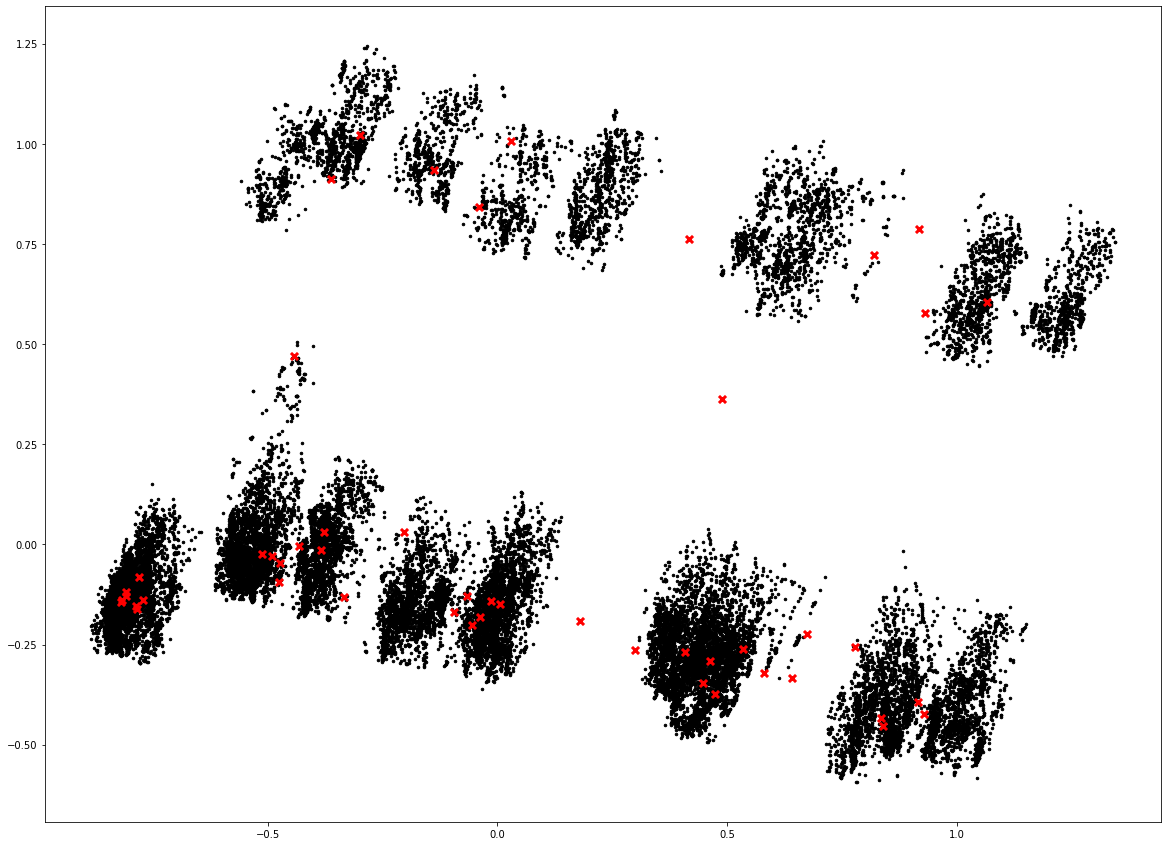

In [339]:
# cluster on instance level 
CLUSTERS = 50
estimator = KMeans(n_clusters=CLUSTERS,random_state=0)#构造聚类器
estimator.fit(vectors)#聚类
label_pred = estimator.labels_ #获取聚类标签
centroids = estimator.cluster_centers_ #获取聚类中心
inertia = estimator.inertia_ # 获取聚类准则的总和

x_min, x_max = vectors[:, 0].min() - 0.1, vectors[:, 0].max() + 0.1
y_min, y_max = vectors[:, 1].min() - 0.1, vectors[:, 1].max() + 0.1

plt.rcParams["figure.figsize"] = (20, 15)

plt.plot(vectors[:, 0], vectors[:, 1], 'k.', markersize=5)
# Plot the centroids as a white X
centroids = estimator.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=50, linewidths=3,
            color='red', zorder=10)
# plt.title('K-means clustering on the TSFresh Features (PCA-reduced data)\n'
#           'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
# plt.xticks(())
# plt.yticks(())
plt.show()


## tagging behaviour vote
top 3 clusters of each movie

In [340]:
df_tagging = pd.concat([train.iloc[:,:3],pd.Series(label_pred)], axis=1)
df_tagging = df_tagging.rename(columns={0:'cluster'})
df_tagging

,userID,movieID,tagID,cluster
0,1751,539,892,12
1,23087,8225,641,5
2,20438,8607,11,18
3,23172,1221,1974,11
4,23172,661,5109,32
...,...,...,...,...
38360,23388,3814,4282,0
38361,37957,7346,16039,6
38362,23172,3176,11246,11
38363,18666,5481,1457,11


In [341]:
# movie center
df_movieC = df_tagging.groupby(['movieID','cluster'])[['userID']].count()
df_movieC = df_movieC.rename(columns={'userID':'count'})
df_movieC = df_movieC.reset_index().sort_values(by=['movieID','count'], ascending=[True,False]).reset_index(drop=True)
df_movieC = df_movieC.reset_index()
df_movieC = df_movieC.rename(columns={'index':'level_1'})
df_movieC

,level_1,movieID,cluster,count
0,0,1,45,6
1,1,1,15,5
2,2,1,24,5
3,3,1,12,4
4,4,1,35,3
...,...,...,...,...
23112,23112,64993,14,3
23113,23113,64993,43,1
23114,23114,65006,14,1
23115,23115,65037,36,6


In [342]:
df_movieC_Top = pd.DataFrame(df_movieC.groupby('movieID').apply(lambda x: x['cluster'][:3])).reset_index() # MAX 3 clusters orig 3743-> 2933 (Top3)
# del df_movieC_Top['level_1']
df_movieC

,movieID,level_1,cluster
0,1,0,45
1,1,1,15
2,1,2,24
3,2,23,17
4,2,24,5
...,...,...,...
11906,64993,23112,14
11907,64993,23113,43
11908,65006,23114,14
11909,65037,23115,36


In [343]:
df_movieC_Top = df_movieC_Top.join(df_movieC.iloc[:,[0,-1]].set_index('level_1'), on='level_1', how='inner')
df_movieC_Top

,movieID,level_1,cluster,count
0,1,0,45,6
1,1,1,15,5
2,1,2,24,5
3,2,23,17,7
4,2,24,5,2
...,...,...,...,...
11906,64993,23112,14,3
11907,64993,23113,43,1
11908,65006,23114,14,1
11909,65037,23115,36,6


In [344]:
dict_Pc = df_movieC_Top.sort_values(by='count', ascending=False).groupby('movieID').apply(lambda x: list(x['cluster']))
dict_Pc

movieID
1        [45, 15, 24]
2          [17, 5, 7]
3         [23, 1, 15]
5        [31, 39, 16]
6         [31, 33, 2]
             ...     
64983            [14]
64993        [14, 43]
65006            [14]
65037            [36]
65130            [36]
Length: 5589, dtype: object

In [345]:
dict_cP = df_movieC_Top.sort_values(by='count', ascending=False).groupby('cluster').apply(lambda x: list(x['movieID']))
# dict_cP = df_movieC_Top.sort_values(by='count', ascending=False).groupby('cluster').apply(lambda x: [list(x['userID']),list(x['count'])])
dict_cP

cluster
0     [3435, 39183, 288, 3379, 1729, 26122, 26838, 1...
1     [5902, 49132, 34162, 41569, 49530, 596, 41566,...
2     [6297, 1590, 924, 318, 10, 1721, 1801, 5903, 2...
3     [7361, 30707, 4878, 5445, 4005, 1732, 593, 299...
4     [33725, 1258, 135, 442, 858, 3266, 4306, 1193,...
5     [1721, 1217, 1354, 593, 4979, 4855, 5105, 4595...
6     [5508, 2797, 318, 47, 8950, 32, 4226, 2571, 40...
7     [4993, 1223, 1198, 26662, 2018, 6787, 2398, 12...
8     [33154, 318, 33615, 5445, 26776, 356, 2985, 56...
9     [198, 1216, 6037, 1210, 5903, 26366, 7762, 833...
10    [59615, 34405, 59315, 55269, 54286, 56788, 597...
11    [3176, 7943, 1810, 2183, 2762, 7843, 296, 8914...
12    [4878, 3160, 5128, 595, 30810, 7767, 6539, 637...
13    [4624, 5747, 1721, 541, 5013, 6016, 589, 480, ...
14    [60069, 58559, 62434, 61323, 43460, 55451, 600...
15    [6218, 546, 7099, 4734, 223, 26662, 1, 1196, 1...
16    [1207, 8199, 4308, 1079, 3788, 750, 1206, 1173...
17    [4478, 2, 940, 41527, 2762, 6680, 

# Test

In [346]:
test.userID.nunique()

1059

In [347]:
test

,userID,movieID,tagID,date_day,date_month,date_year,date_hour,date_minute,date_second,timestamps,...,weekofyear,quarter,days_in_month,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_leap_year
0,190,31184,712,16,4,2008,19,0,5,2008-04-16 19:00:05,...,16,2,30,False,False,False,False,False,False,True
1,31175,3317,501,9,5,2006,22,32,35,2006-05-09 22:32:35,...,19,2,31,False,False,False,False,False,False,False
2,33384,1554,634,12,5,2007,21,34,20,2007-05-12 21:34:20,...,19,2,31,False,False,False,False,False,False,False
3,23388,780,7071,13,2,2007,0,51,29,2007-02-13 00:51:29,...,7,1,28,False,False,False,False,False,False,False
4,43699,1958,247,24,8,2006,5,30,34,2006-08-24 05:30:34,...,34,3,31,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9587,17463,357,3840,4,10,2008,23,17,59,2008-10-04 23:17:59,...,40,4,31,False,False,False,False,False,False,True
9588,24476,594,2955,15,3,2006,17,17,10,2006-03-15 17:17:10,...,11,1,31,False,False,False,False,False,False,False
9589,37216,1947,247,10,5,2006,6,40,45,2006-05-10 06:40:45,...,19,2,31,False,False,False,False,False,False,False
9590,33384,3438,7408,3,7,2007,1,6,58,2007-07-03 01:06:58,...,27,3,31,False,False,False,False,False,False,False


In [348]:
df_selected_test = test.iloc[:,:].filter(regex="[^time_stamp]")
df_selected_test

,userID,movieID,tagID,date_day,date_month,date_year,date_hour,date_minute,date_second,dayofweek_num,weekofyear,quarter,days_in_month,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_leap_year
0,190,31184,712,16,4,2008,19,0,5,2,16,2,30,False,False,False,False,False,False,True
1,31175,3317,501,9,5,2006,22,32,35,1,19,2,31,False,False,False,False,False,False,False
2,33384,1554,634,12,5,2007,21,34,20,5,19,2,31,False,False,False,False,False,False,False
3,23388,780,7071,13,2,2007,0,51,29,1,7,1,28,False,False,False,False,False,False,False
4,43699,1958,247,24,8,2006,5,30,34,3,34,3,31,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9587,17463,357,3840,4,10,2008,23,17,59,5,40,4,31,False,False,False,False,False,False,True
9588,24476,594,2955,15,3,2006,17,17,10,2,11,1,31,False,False,False,False,False,False,False
9589,37216,1947,247,10,5,2006,6,40,45,2,19,2,31,False,False,False,False,False,False,False
9590,33384,3438,7408,3,7,2007,1,6,58,1,27,3,31,False,False,False,False,False,False,False


In [349]:
df_selected.shape

(38365, 20)

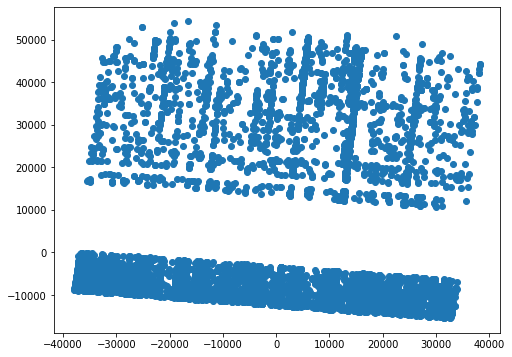

In [350]:
# scaler = MinMaxScaler()
df_selected_test = scaler.transform(df_selected_test)
# scaler.inverse_transform(df_selected)

vectors = pca1.fit_transform(df_selected_test)#高维度PCA降维到2维
plt.rcParams["figure.figsize"] = (8, 6)
plt.scatter(vectors[:,0],vectors[:,1]) # user

In [351]:
vectors.shape

(9592, 20)

In [352]:
estimator.transform(vectors).shape #聚类坐标

(9592, 50)

In [353]:
label_pred_test = estimator.predict(vectors) # 预测test set的类
label_pred_test

array([ 6, 27, 27, ..., 21, 30, 27], dtype=int32)

In [354]:
test.loc[:,'pred_cluster'] = label_pred_test
test

/home/liu/venv-neu/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/liu/venv-neu/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,userID,movieID,tagID,date_day,date_month,date_year,date_hour,date_minute,date_second,timestamps,...,quarter,days_in_month,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_leap_year,pred_cluster
0,190,31184,712,16,4,2008,19,0,5,2008-04-16 19:00:05,...,2,30,False,False,False,False,False,False,True,6
1,31175,3317,501,9,5,2006,22,32,35,2006-05-09 22:32:35,...,2,31,False,False,False,False,False,False,False,27
2,33384,1554,634,12,5,2007,21,34,20,2007-05-12 21:34:20,...,2,31,False,False,False,False,False,False,False,27
3,23388,780,7071,13,2,2007,0,51,29,2007-02-13 00:51:29,...,1,28,False,False,False,False,False,False,False,30
4,43699,1958,247,24,8,2006,5,30,34,2006-08-24 05:30:34,...,3,31,False,False,False,False,False,False,False,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9587,17463,357,3840,4,10,2008,23,17,59,2008-10-04 23:17:59,...,4,31,False,False,False,False,False,False,True,22
9588,24476,594,2955,15,3,2006,17,17,10,2006-03-15 17:17:10,...,1,31,False,False,False,False,False,False,False,22
9589,37216,1947,247,10,5,2006,6,40,45,2006-05-10 06:40:45,...,2,31,False,False,False,False,False,False,False,21
9590,33384,3438,7408,3,7,2007,1,6,58,2007-07-03 01:06:58,...,3,31,False,False,False,False,False,False,False,30


In [356]:
df_tagging[df_tagging.userID==190].cluster.value_counts() # 190用户有15条记录在42类，有3条在0类

42    15
0      3
11     1
21     1
Name: cluster, dtype: int64

In [357]:
df_tagging[df_tagging.movieID==31184]

,userID,movieID,tagID,cluster
40,28855,31184,8386,46
541,35373,31184,13995,19
2372,13014,31184,712,28
4644,48717,31184,15689,37


In [358]:
dict_UP = df_tagging.groupby('userID').apply(lambda x: list(x['movieID']))
dict_UP

userID
75                                                   [353]
78                                                  [4223]
127      [8622, 4447, 7147, 7147, 8622, 7147, 1343, 427...
170                                                [47830]
175                                          [51540, 2819]
                               ...                        
71497    [954, 1197, 54259, 54259, 1682, 1682, 1610, 44...
71509    [30850, 55363, 2983, 3873, 50259, 7396, 680, 7...
71525                                              [45447]
71529                                         [6377, 1196]
71534    [933, 39, 3448, 1394, 7084, 930, 971, 903, 202...
Length: 1919, dtype: object

In [405]:
dict_PU = df_tagging.groupby('movieID').apply(lambda x: list(x['userID']))
dict_PU

movieID
1        [38390, 5002, 33384, 47780, 57912, 28122, 3615...
2        [16610, 33384, 33384, 52806, 47384, 8423, 6937...
3                      [69374, 51191, 69374, 15264, 48717]
5               [49265, 65436, 49265, 65436, 64540, 49265]
6        [53241, 6532, 18015, 23388, 41838, 43699, 2317...
                               ...                        
64983                                       [33384, 33384]
64993                         [50846, 50846, 50846, 50846]
65006                                              [56091]
65037           [30879, 30879, 30879, 30879, 30879, 30879]
65130                                              [26116]
Length: 5589, dtype: object

In [360]:
dict_UP[190]
# dict_PU[3317]

[5618,
 5952,
 5690,
 3997,
 5072,
 26662,
 2810,
 6350,
 6283,
 31658,
 5069,
 8607,
 5146,
 3000,
 2116,
 741,
 31660,
 4993,
 7099,
 1274]

In [387]:
dict_Pc[5618]

[18, 25, 8]

In [355]:

# 是有用户出现——> 老用户 -》 推荐相关的， 还是有用户行为出现->预测行为的temporal 类-》推荐

# 或者目前使用的：用户行为出现 -》 输入 用户，行为时间 ——》 Scale, PCA处理时间，并以此作为特征预测tempral 类 
# -> 根据temporal 类里其他用户和原有相似用户的交集选择candidate用户
# -》推荐candidate 用户喜好的（在同个temporal类里）top N

In [432]:
# 测试新方法:
# 对于测试集里的每一行数据，拿到 ID， 看过的P，以及给它预测的pred_cluster,
# 如果是老用户， 直接使用用户被预测的cluster得到同组其他的用户 作为candidates (通过cU)
# 再通过 UP 得到所有目标用户watched的 movie 
# 再根据 PU 得到每一部watched movie还有哪些其他的user 看过
# 然后这个通过PU得到的candidates 和之前通过cU得到的candiates 作交集，得到最终的User candidates
# 对于每一个user candidates, 用UP找出所有他们所看过的电影，作为Product candidates
# 记录每一个目标用户的 U cand and UP cand length
# 最后对比每一个ground truth P 是否在 P cand 中， 类似于recall
res,len_U,len_UP = [],[],[]

for i in range(len(test)):
    U = test['userID'][i]
    P_true = test['movieID'][i]
    c_pred = test['pred_cluster'][i]
#     U_cand = dict_PU[P]
    if U in dict_UP:
#         cP_cands = set(dict_cP[c_pred])
        cU_cands = set(dict_cU[c_pred]) # new user can only use cU and no PU 
    
        watched = dict_UP[U]
        PU_cands = set()
        for movie in watched:
            for u in dict_PU[movie]:
                PU_cands.add(u)
#         U_cands = cU_cands.union(PU_cands)
        U_cands = cU_cands.intersection(PU_cands)
        UP_cands = set()
    
        for u in U_cands:
            for p in dict_UP[u]:
                UP_cands.add(p)
        
        len_U.append(len(U_cands))
        len_UP.append(len(UP_cands))
        
        # verify
        if P_true in UP_cands:
            res.append(1)
        else: 
            res.append(0)
        
    else:
        print(f"error: {U} is new user")
        res.append(0)

error: 49032 is new user
error: 49148 is new user
error: 32299 is new user
error: 55560 is new user
error: 32031 is new user
error: 38882 is new user
error: 50156 is new user
error: 18304 is new user
error: 15974 is new user
error: 20144 is new user
error: 15816 is new user
error: 42054 is new user
error: 16302 is new user
error: 51972 is new user
error: 23260 is new user
error: 55403 is new user
error: 3710 is new user
error: 2435 is new user
error: 53045 is new user
error: 17307 is new user
error: 27713 is new user
error: 51301 is new user
error: 27620 is new user
error: 41103 is new user
error: 27152 is new user
error: 32283 is new user
error: 1860 is new user
error: 42237 is new user
error: 61592 is new user
error: 62252 is new user
error: 13748 is new user
error: 25976 is new user
error: 15716 is new user
error: 43205 is new user
error: 57082 is new user
error: 7685 is new user
error: 70789 is new user
error: 59995 is new user
error: 58763 is new user
error: 35601 is new user
erro

In [433]:
pd.Series(len_U).value_counts()

18    638
17    403
9     392
15    358
35    351
     ... 
80      8
55      8
50      5
52      5
51      1
Length: 63, dtype: int64

<AxesSubplot:ylabel='Frequency'>

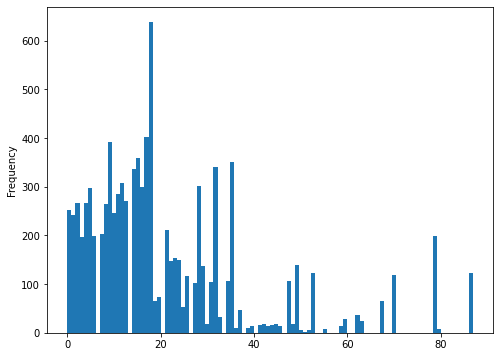

In [437]:
pd.Series(len_U).plot.hist(bins=100)

In [439]:
pd.Series(len_UP).value_counts()

535     476
1054    340
1074    298
0       253
530     242
       ... 
243       1
171       1
59        1
51        1
88        1
Length: 764, dtype: int64

<AxesSubplot:ylabel='Frequency'>

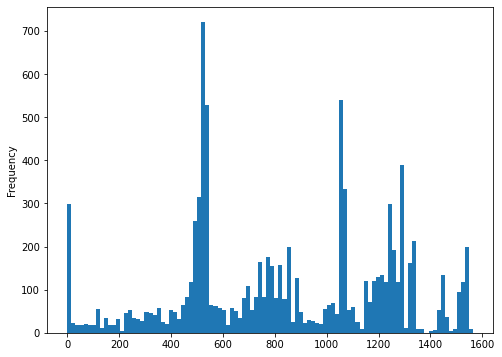

In [440]:
pd.Series(len_UP).plot.hist(bins=100)

In [423]:
pd.Series(res).value_counts()

0    6026
1    3566
dtype: int64

In [426]:
3566/len(test)

0.37176814011676396

# CF

In [50]:
# https://realpython.com/build-recommendation-engine-collaborative-filtering/
# 无法再binary上使用
import pandas as pd
from surprise import Dataset
from surprise import Reader

# This is the same data that was plotted for similarity earlier
# with one new user "E" who has rated only movie 1
ratings_dict = {
    "item": [1, 2, 1, 2, 1, 2, 1, 2, 1],
    "user": ['A', 'A', 'B', 'B', 'C', 'C', 'D', 'D', 'E'],
#     "rating": [1, 2, 2, 4, 2.5, 4, 4.5, 5, 3],
    "rating": [1, 1, 1, 0, 1, 0, 0, 1, 1],
    
}

df = pd.DataFrame(ratings_dict)
reader = Reader(rating_scale=(1, 5))

# Loads Pandas dataframe
data = Dataset.load_from_df(df[["user", "item", "rating"]], reader)
# Loads the builtin Movielens-100k data
movielens = Dataset.load_builtin('ml-100k')

In [51]:
df

,item,user,rating
0,1,A,1
1,2,A,1
2,1,B,1
3,2,B,0
4,1,C,1
5,2,C,0
6,1,D,0
7,2,D,1
8,1,E,1


In [4]:
from surprise import KNNWithMeans

# To use item-based cosine similarity
sim_options = {
    "name": "cosine",
    "user_based": False,  # Compute  similarities between items
}
algo = KNNWithMeans(sim_options=sim_options)

In [5]:
trainingSet = data.build_full_trainset()

algo.fit(trainingSet)

Computing the cosine similarity matrix...
Done computing similarity matrix.


/home/liu/venv-neu/lib/python3.8/site-packages/surprise/prediction_algorithms/algo_base.py:249: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


In [6]:
prediction = algo.predict('E', 2)
prediction.est

1

# Movielens CF

In [136]:
df['dummy'] = [1] * len(df)
df

,userID,movieID,tagID,date_day,date_month,date_year,date_hour,date_minute,date_second,dummy
0,75,353,5290,29,10,2006,23,20,15,1
1,78,4223,5264,16,4,2007,4,43,45,1
2,127,1343,1544,28,8,2007,3,42,27,1
3,127,1343,12330,28,8,2007,3,42,27,1
4,127,2080,1451,28,8,2007,3,42,47,1
...,...,...,...,...,...,...,...,...,...,...
47952,71534,7937,306,3,12,2007,3,7,14,1
47953,71534,8848,331,3,12,2007,3,6,19,1
47954,71534,8848,427,3,12,2007,3,6,27,1
47955,71534,25833,7671,3,12,2007,3,7,31,1


In [140]:
df = df.groupby(['userID','movieID'])[['dummy']].count().reset_index()
df

,userID,movieID,dummy
0,75,353,1
1,78,4223,1
2,127,1343,2
3,127,2080,2
4,127,2953,2
...,...,...,...
27707,71534,7084,2
27708,71534,7937,1
27709,71534,8848,2
27710,71534,25833,1


In [143]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train.shape, df_test.shape

((22169, 3), (5543, 3))

In [148]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [190]:
df_test

,userID,movieID,dummy
0,8683,25850,2
1,53192,7247,1
2,62348,3094,1
3,70974,1135,1
4,44294,3105,1
...,...,...,...
5538,19885,4699,1
5539,65436,950,1
5540,43189,1977,1
5541,23388,8264,4


In [194]:
test_UP = df_test.groupby('userID').apply(lambda x: list(x['movieID']))
test_UP[127]

[4447, 2080]

<AxesSubplot:ylabel='Frequency'>

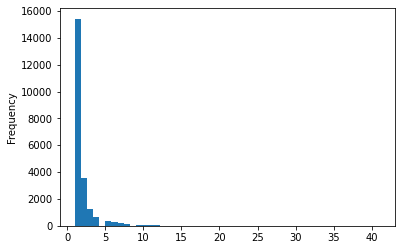

In [152]:
df_train.dummy.plot.hist(bins=50)

In [155]:
df_cf = pd.pivot_table(df_train, values='dummy', index=['userID'],columns=['movieID']) #,aggfunc=np.sum
df_cf = df_cf.fillna(0)
df_cf

movieID,1,2,3,5,6,7,8,10,11,12,...,64622,64701,64716,64957,64983,64993,65006,65037,65126,65130
userID,,,,,,,,,,,,,,,,,,,,,
75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
170,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [167]:
# # map movie, user to new index id
dict_uid = dict(pd.Series(df_cf.index))
# dict_pid = dict(pd.Series(df_cf.columns))

# df_cf.columns = range(df_cf.shape[1])
# df_cf = df_cf.reset_index(drop=True)

In [158]:
df_cf.T.sum().median(), df_cf.T.sum().mean()

(2.0, 19.978125)

In [237]:
# https://towardsdatascience.com/item-based-collaborative-filtering-in-python-91f747200fab

from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(df_cf.values)
distances, indices = knn.kneighbors(df_cf.values, n_neighbors=50)

In [238]:
indices

array([[   0, 1432,  247, ..., 1279, 1272, 1299],
       [   1,  210,  194, ..., 1282, 1284, 1259],
       [   2, 1808, 1816, ..., 1849, 1865,  448],
       ...,
       [1917, 1657,  635, ..., 1877,  428,  628],
       [1918, 1372, 1248, ..., 1280, 1275, 1312],
       [1919,  165,  923, ..., 1299,  308, 1292]])

In [188]:
df_cf.index.tolist().index(127)

2

In [239]:
# get the index for 'user:127'
UID = 127

index_for_user = df_cf.index.tolist().index(UID)
# find the indices for the similar movies
sim_movies = [dict_uid[id] for id in indices[index_for_user].tolist()]
sim_movies.remove(UID)

print('The Nearest Users to user_127:', sim_movies)

The Nearest Users to user_127: [68151, 68441, 69135, 42201, 477, 23953, 69820, 1035, 66190, 64294, 68989, 66207, 68773, 69590, 8892, 12759, 68304, 59012, 3017, 1392, 70421, 63347, 25197, 66227, 68523, 68516, 68046, 69195, 33943, 28855, 70760, 70299, 66784, 70102, 70816, 22957, 57475, 60713, 68810, 23172, 17647, 1282, 22936, 17312, 48717, 788, 69374, 69875, 16610]


In [195]:
# distances between 'user:127' and the similar users
movie_distances = distances[index_for_user].tolist()

print('The Distance from user_127:', movie_distances) # cosine distance

The Distance from user_127: [1.1102230246251565e-16, 0.33184689521893906, 0.5401454953862757, 0.5747899678646193, 0.6142416250947702]


In [231]:
df_test[df_test.userID==127]

,userID,movieID,dummy
448,127,4447,3
4542,127,2080,2


In [274]:
df_train[df_train.userID==UID]['movieID'].tolist()

[5679, 2953, 6934, 4270, 8622, 1343, 7147]

In [277]:
len(set(cand_P)-set(df_train[df_train.userID==UID]['movieID'].tolist()))

1552

In [278]:
test_UP.index[:3]

Int64Index([127, 190, 325], dtype='int64', name='userID')

In [281]:
test_UP[190]

[8607, 26662, 2810, 6283, 6350, 5072]

In [330]:
[1,2,3].remove([1,2])

ValueError: list.remove(x): x not in list

In [345]:
cand_P = pd.DataFrame(df_train[df_train.userID.isin(sim_movies)].groupby('movieID')['dummy'].count().sort_values(ascending=False))
watched = set(df_train[df_train.userID==UID]['movieID'].tolist())
# cand_P = cand_P[~cand_P.index.isin(watched)]
cand_P

,dummy
movieID,
7153,20
4993,17
5952,16
3000,15
7099,14
...,...
3087,1
3146,1
3157,1


In [429]:
# UID=190
# index_for_user = df_cf.index.tolist().index(UID)
# sim_movies = [dict_uid[id] for id in indices[index_for_user].tolist()]
# sim_movies.remove(UID)
# cand_P = pd.DataFrame(df_train[df_train.userID.isin(sim_movies)].groupby('movieID')['dummy'].count().sort_values(ascending=False))
# watched = df_train[df_train.userID==UID]['movieID'].tolist()
# cand_P = cand_P[~cand_P.index.isin(watched)] # remove watched movie
# cand_P = cand_P.index.tolist()#[:100] # select top N
# round(len(set(test_UP[190]) & set(cand_P)) / (len(cand_P)+1e-9),3)

0.006

In [432]:
recommender_precision([list(cand_P)],[list(test_UP[190])])

0.0063

In [433]:
recommender_recall([list(cand_P)],[list(test_UP[190])])

1.0

In [414]:
mark([list(test_UP[190])],[list(cand_P)], 10)

0.3333333333333333

In [425]:
mapk([list(test_UP[190])],[list(cand_P)], 10)

0.2

In [426]:
cand_P[:10]

[26776, 6350, 541, 7438, 6539, 26662, 8961, 593, 296, 33004]

In [406]:
test_UP[190]

[8607, 26662, 2810, 6283, 6350, 5072]

In [442]:
test_UP

userID
127                                           [4447, 2080]
190                  [8607, 26662, 2810, 6283, 6350, 5072]
325                                                [45720]
383                                                 [6270]
477                              [1274, 54001, 1608, 2023]
                               ...                        
71497                     [858, 44191, 954, 54259, 1, 261]
71509    [1162, 4072, 6257, 3645, 26211, 5488, 26064, 4...
71525                                              [45447]
71529                                               [1196]
71534                  [3307, 7084, 903, 1221, 1247, 8848]
Length: 961, dtype: object

In [600]:
# recommend movie for test set users
pred_res = []
accs = {500:[],100:[],50:[],20:[], 15:[], 10:[],5:[]}
recalls = {500:[],100:[],50:[],20:[], 15:[], 10:[],5:[]}

for UID in test_UP.index:
    if UID in df_cf.index: #if it is not new user
        index_for_user = df_cf.index.tolist().index(UID)
        sim_movies = [dict_uid[i] for i in indices[index_for_user].tolist()]
        sim_movies.remove(UID)
        cand_P = pd.DataFrame(df_train[df_train.userID.isin(sim_movies)].groupby('movieID')['dummy'].count().sort_values(ascending=False))
        watched = df_train[df_train.userID==UID]['movieID'].tolist()
        cand_P = cand_P[~cand_P.index.isin(watched)] # remove watched movie
        cand_P = cand_P.index.tolist()[:1000] # select max top 1000
    else:
        cand_P = []
#         print(UID, "is new user")
    pred_res.append(cand_P)
#     print(round(len(set(test_UP[UID]) & set(cand_P)) / (len(cand_P)+1e-9),3))
    
    for topN in list(accs.keys()):
        cand_P = cand_P[:topN]
        acc = round(len(set(test_UP[UID]) & set(cand_P)) / (len(cand_P)+1e-9),3)
        accs[topN].append(acc)
        recall = round(len(set(test_UP[UID]) & set(cand_P)) / (len(set(test_UP[UID]))+1e-9),3)
        recalls[topN].append(recall)
        
#     print(UID)
#     print(acc)
#     print(recommender_precision([list(cand_P)],[list(test_UP[UID])]))
#     print(mapk([list(test_UP[UID])],[list(cand_P)], 100))

Text(0.5, 1.0, 'Average Precision @TopN')

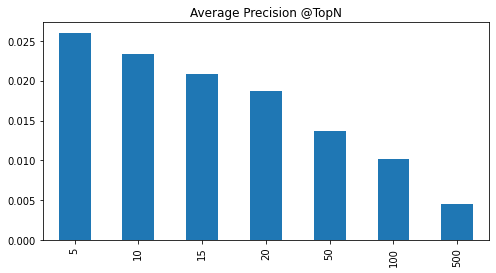

In [801]:
# X: TopN Y:ACC/Precision
plt.rcParams["figure.figsize"] = (8,4)
pd.Series(dict([(k,np.array(v).mean()) for k,v in accs.items()])).sort_index().plot.bar()
plt.title("Average Precision @TopN")

Text(0.5, 1.0, 'Average Recall @TopN')

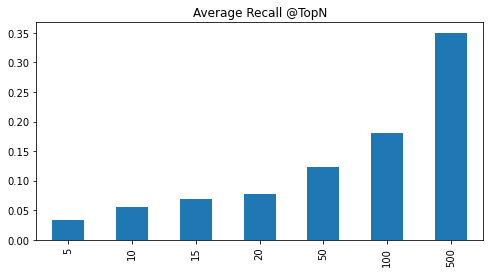

In [802]:
# [(k,np.array(v).mean()) for k,v in recalls.items()]
pd.Series(dict([(k,np.array(v).mean()) for k,v in recalls.items()])).sort_index().plot.bar()
plt.title("Average Recall @TopN")

Text(0.5, 1.0, 'Average F1-score @TopN')

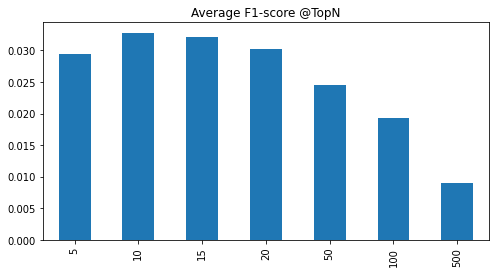

In [734]:
rec = np.array([np.array(v).mean() for k,v in recalls.items()])
pre = np.array([np.array(v).mean() for k,v in accs.items()])
f1 = 2* rec * pre /(rec + pre)
pd.Series(f1,accs.keys()).sort_index().plot.bar()
plt.title("Average F1-score @TopN")

# Evaluation

In [560]:
# from sklearn import metrics
# y_true = [1,1,1,0]
# y_pred = [1,0,1,0]
# metrics.precision_score(y_true, y_pred)
# # metrics.precision_score(y_true, y_pred, average='micro'),metrics.precision_score(y_true, y_pred, average='macro')

1.0

In [826]:
from mymetrics import *

recommender_precision(pred_res,test_UP.true),recommender_recall(pred_res,test_UP.true)

(0.0032568158168574403, 0.4295925078043704)

In [792]:
mapk(test_UP.true,pred_res, 10),mark(test_UP.true,pred_res, 10)

(0.023309053069719043, 0.05522207470506614)

In [812]:
mapk(test_UP.true,pred_res, 5),mark(test_UP.true,pred_res, 5)

(0.026014568158168577, 0.03378758640616312)

In [619]:
df.set_index('userID').index

,movieID,dummy
userID,,
75,353,1
78,4223,1
127,1343,2
127,2080,2
127,2953,2
...,...,...
71534,7084,2
71534,7937,1
71534,8848,2


In [775]:
clusters = [0, 1, 5, 10, 20, 50, 100, 200, 1469]
user_clusters = {}
for i in range(len(clusters)-1):
    IDs = df.groupby('userID').count()['dummy'].apply(lambda x: x>clusters[i] and x<=clusters[i+1])
    user_clusters[str(clusters[i])+'_'+str(clusters[i+1])] =  list(IDs[IDs==True].index)

In [776]:
t = 0
for k,v in user_clusters.items():
    t+=len(v)
    print(k+':',len(v))
t

0_1: 948
1_5: 632
5_10: 170
10_20: 148
20_50: 114
50_100: 49
100_200: 28
200_1469: 24


2113

In [777]:
# 每个用户有多少个tagging的value统计 多数只有1个tag
# df.groupby('userID').count().sort_values(by=['dummy'],ascending=True)['dummy'].value_counts()

In [778]:
test_UP = pd.DataFrame(test_UP)
test_UP['pred'] = pred_res
test_UP = test_UP.rename(columns={0:'true'})
test_UP

,true,pred
userID,,
127,"[4447, 2080]","[3785, 4367, 5952, 4993, 4975, 2571, 7438, 561..."
190,"[8607, 26662, 2810, 6283, 6350, 5072]","[26776, 6350, 541, 7438, 6539, 26662, 8961, 59..."
325,[45720],"[296, 32, 2858, 44191, 318, 32587, 1258, 2959,..."
383,[6270],"[1288, 480, 2329, 608, 34405, 150, 356, 1732, ..."
477,"[1274, 54001, 1608, 2023]","[3785, 296, 3033, 7438, 5377, 778, 1179, 589, ..."
...,...,...
71497,"[858, 44191, 954, 54259, 1, 261]","[1210, 260, 2571, 318, 2628, 1, 4226, 1240, 29..."
71509,"[1162, 4072, 6257, 3645, 26211, 5488, 26064, 4...","[34405, 7361, 4226, 39183, 593, 608, 2858, 296..."
71525,[45447],[]


0_1: 0.0
1_5: 0.0006751724137931034
5_10: 0.0011300751879699247
10_20: 0.0022492753623188405
20_50: 0.005135964912280703
50_100: 0.008608163265306123
100_200: 0.015464285714285717
200_1469: 0.04304166666666667
ALL: 0.0032568158168574403


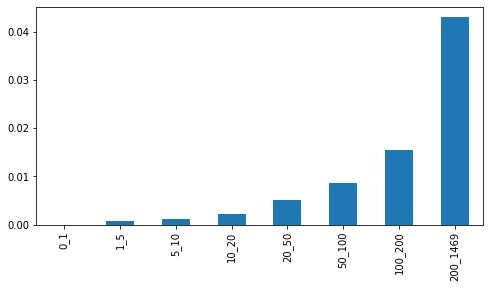

In [779]:
# Precision
def metrics_clusters(f=recommender_precision, res=test_UP,verbose=0):
  plt.rcParams["figure.figsize"] = (8,4)
  res_dict = {}
  for k,v in user_clusters.items():
    res_dict[k] = f(res.pred[set(v) & set(test_UP.index)], res.true[set(v) & set(test_UP.index)])
  if verbose == 1:
    for k,v in res_dict.items():
      print(k+':',v)
    print('ALL:',f(res.pred, res.true))
  pd.Series(res_dict).plot.bar()
metrics_clusters(verbose=1)

0_1: 0.0
1_5: 0.5428158620689656
5_10: 0.5593984962406016
10_20: 0.5459804347826087
20_50: 0.4832640350877192
50_100: 0.4998551020408164
100_200: 0.51925
200_1469: 0.4813541666666667
ALL: 0.4295925078043704


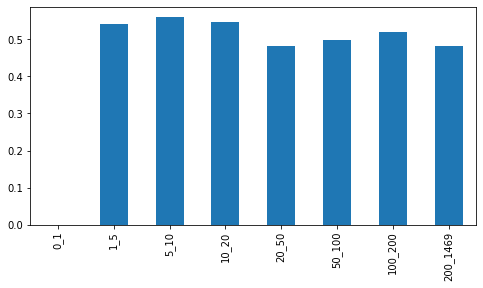

In [780]:
metrics_clusters(f=recommender_recall,verbose=1)

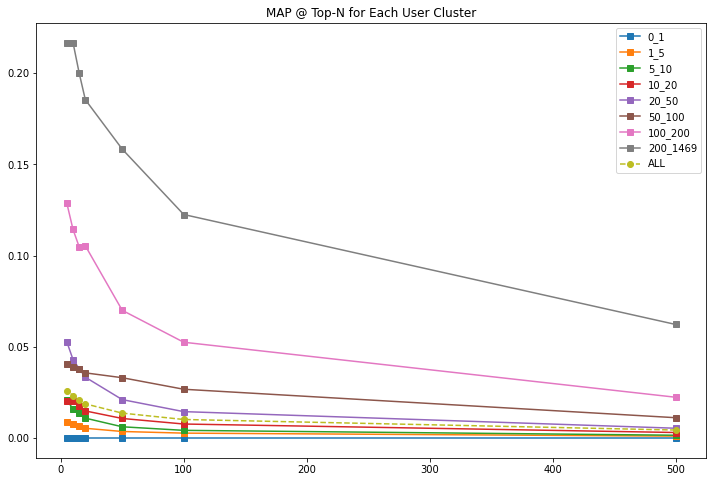

In [820]:
def metrics_map(f=mapk, res=test_UP):
    plt.rcParams["figure.figsize"] = (12,8)
    ks = list(accs.keys()) #[500, 100, 50, 20, 15, 10, 5]
    for _,v in user_clusters.items():
      maps = {}
      v = set(v) & set(df_test.userID)
      for k in ks:
        maps[k] = f(res.true[v],res.pred[v], k=k)
      pd.Series(maps).plot(style='s-')
    map_all = pd.Series([f(res.true,res.pred, k=k) for k in ks])
    map_all.index=ks
    map_all.plot(style='o--')
    legends = list(user_clusters.keys())
    legends.append('ALL')
    plt.legend(legends)
    plt.title(f"MAP @ Top-N for Each User Cluster")
    
metrics_map()

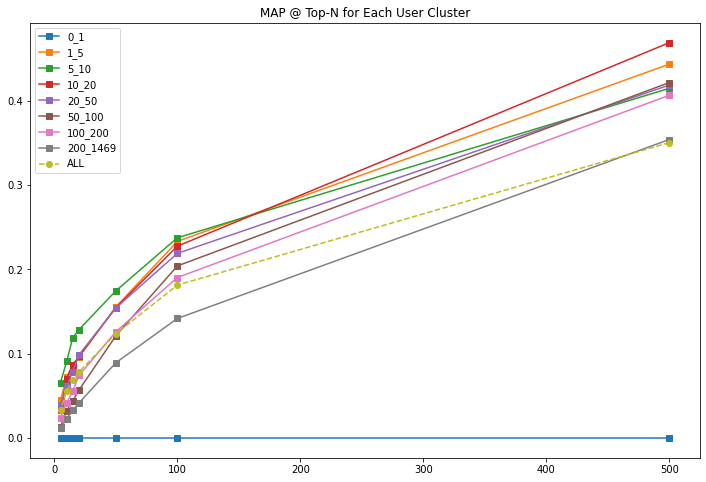

In [821]:
metrics_map(mark)